<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# DBSCAN

_Authors: Matt Brems (DC), Riley Dallas (AUS)_

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris, load_wine
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

## Where `DBSCAN` shines
---

`DBSCAN` does really well when there is clear "separation" within your dataset. `load_iris` is a good example of this, because one of the species is an island unto itself.

**In the cell below, load the iris dataset into a `pandas` DataFrame. Ignore the species.**

In [2]:
data = load_iris()

df = pd.DataFrame(data.data, columns = data.feature_names)

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## Preprocessing: `StandardScaler`
---

Because clustering models are based on distance, we don't want the magnitude of our features to affect the algorithm. Therefore, when clustering **you should always scale your data**.

Create `X_scaled` using an instance of `StandardScaler` in the cell below.

In [3]:
sc = StandardScaler()

X_sc = sc.fit_transform(df)

## `DBSCAN`
---

Fit an instance of `DBSCAN` to `X_Scaled`. Use the default parameters for now (we'll tune them in a minute).

In [4]:
dbscan = DBSCAN()

dbscan.fit(X_sc)

DBSCAN()

## Model Evaluation: Silhouette score
---

Recall the formula for Silhouette score:

### $s_i = \frac{b_i - a_i}{max\{a_i, b_i\}}$

Where:
- $a_i$ = Cohesion: Average distance of points within clusters
- $b_i$ = Separation: Average distance from point $x_i$ to all points in the next nearest cluster.

In the cell below, use the `silhouette_score` function from `sklearn` to evaluate our `DBSCAN` model.

In [5]:
silhouette_score(X_sc, dbscan.labels_)

0.3565164814270073

## EDA: `pairplot`
---

Now let's view our clusters using `seaborn`'s `pairplot` method. 

1. First, you'll need to assign the clusters (`dbscan.labels_`) to your original DataFrame.
2. Then you'll create a `pairplot` using the `cluster` column as the hue

In [6]:
# How many of each label are there?

pd.Series(dbscan.labels_).value_counts()

 1    71
 0    45
-1    34
dtype: int64

In [7]:
# Create cluster column

df['cluster'] = dbscan.labels_

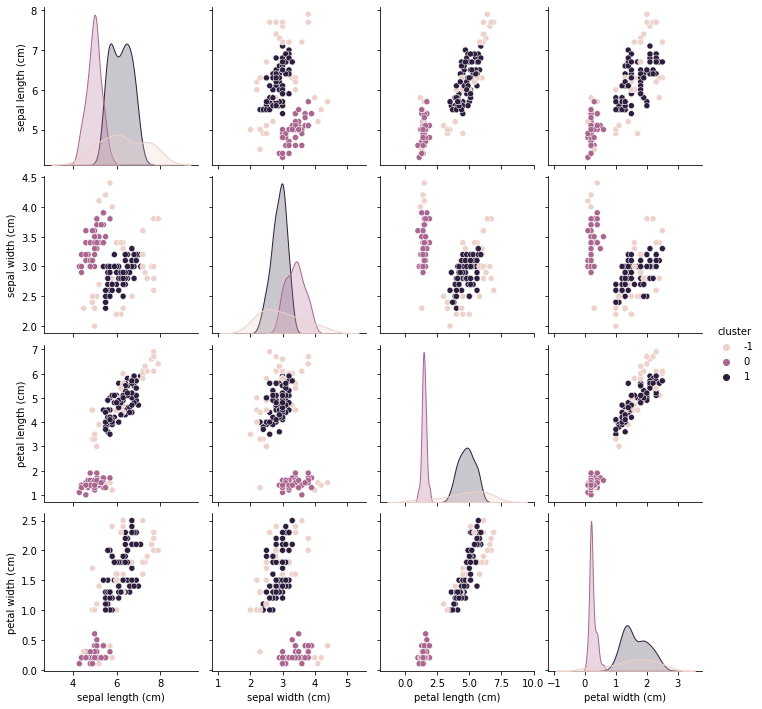

In [8]:
# Pairplot

sns.pairplot(df, hue = 'cluster');

## Choosing the Best Value for Epsilon

In [9]:
# calculate the distances to k nearest neighbors for each point

from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors = 5)

nbrs.fit(X_sc)

distances, indices = nbrs.kneighbors(X_sc)

In [10]:
# the indices show us the index values from X_sc of the k nearest neighbors of each point

indices[:5]

array([[ 0, 17, 27, 40, 39],
       [ 1, 25, 45, 12, 34],
       [ 2, 47, 29,  3, 30],
       [ 3, 47, 30, 29,  2],
       [ 4, 37,  0, 40, 17]])

In [11]:
# show the points in the first "neighborhood"

X_sc[indices[0]]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-0.90068117,  1.01900435, -1.34022653, -1.18381211],
       [-0.7795133 ,  1.01900435, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.01900435, -1.39706395, -1.18381211],
       [-0.90068117,  0.78880759, -1.2833891 , -1.3154443 ]])

In [12]:
# view the distances between points in a neighborhood

distances[:5]

array([[0.        , 0.13163218, 0.13383627, 0.18772101, 0.23710977],
       [0.        , 0.16614339, 0.17890971, 0.17890971, 0.23710977],
       [0.        , 0.13383627, 0.17051228, 0.28389113, 0.31104122],
       [0.        , 0.23710977, 0.24891184, 0.2662756 , 0.28389113],
       [0.        , 0.17890971, 0.26013882, 0.27119749, 0.29154628]])

In [13]:
# we just want the distance of the farthest point in the neighborhood

distances = distances[:, -1]

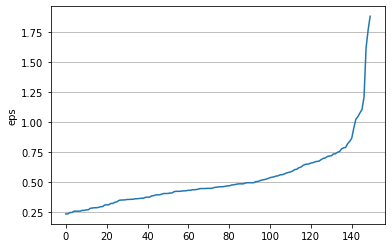

In [15]:
# sort the values and plot the distances
import numpy as np

distances = np.sort(distances)
plt.plot(distances)
plt.ylabel('eps')
plt.grid(axis = 'y');

In [16]:
# make a new model with the updated parameters

model = DBSCAN(eps = 0.8)

model.fit(X_sc)

DBSCAN(eps=0.8)

In [17]:
# get the silhouette score of new model

silhouette_score(X_sc, model.labels_)

0.5216965052515835

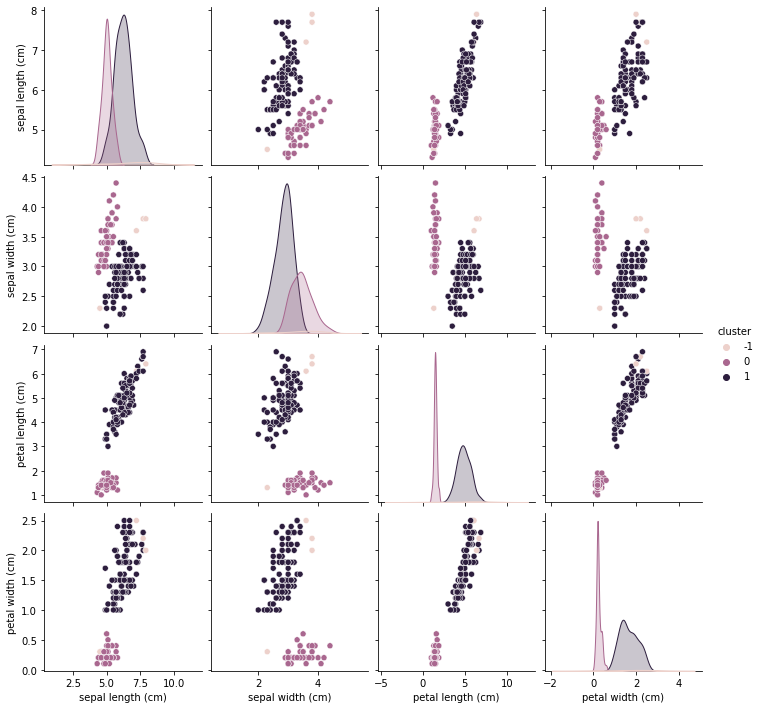

In [18]:
# update df with the new labels and view the pairplot

df['cluster'] = model.labels_

sns.pairplot(df, hue = 'cluster');

## Where `DBSCAN` does poorly
---

`DBSCAN` is dependent on two things:

1. Consistent density (one `eps` to rule them all)
2. Clear separation of the clusters within your dataset

The `load_wine` dataset is more or less clumped together, which makes it a great dataset for exposing one of the weaknesses of `DBSCAN`: no clear separation.

In the cell below, load the wine dataset into a `pandas` DataFrame. Ignore the target.

In [19]:
wine = load_wine()

wine_df = pd.DataFrame(wine.data, columns = wine.feature_names)

wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


## Preprocessing: `StandardScaler`
---

Because clustering models are based on distance, we don't want the magnitude of our features to affect the algorithm. Therefore, when clustering **you should always scale your data**.

Create `X_scaled` using an instance of `StandardScaler` in the cell below.

In [20]:
X_sc = StandardScaler().fit_transform(wine_df)

## `DBSCAN`
---

Fit an instance of `DBSCAN` to `X_Scaled`. Finding the right values for `eps` and `min_samples` can take a while, so to save on time we'll use the following parameters:

- 2.3 for `eps`
- 4 for `min_samples`

In [21]:
dbscan = DBSCAN(eps = 2.3, min_samples = 4)

dbscan.fit(X_sc)

set(dbscan.labels_)

{-1, 0, 1}

## Model evaluation
---

Calculate the silhouette score for our instance of `DBSCAN` in the cell below.

In [22]:
silhouette_score(X_sc, dbscan.labels_)

0.1971962127390583

## EDA
---

It's not practical to create a `pairplot` because the wine dataset has several features. We'll try some different techniques in a bit.

In the cell below, create a `cluster` column using `dbscan.labels_`.

In [23]:
# Create cluster column
wine_df['cluster'] = dbscan.labels_

In [24]:
# Value counts for each cluster
wine_df['cluster'].value_counts()

 0    99
 1    43
-1    36
Name: cluster, dtype: int64

## Exploring each cluster
---

Clustering is sort of backwards: We fit a model, **then** we do EDA on each cluster. You can go one of two routes:

1. Break each cluster into its own DataFrame
2. Use `.groupby()` extensively

In the cell below, use `.groupby()` in conjunction with `.mean()` and see if you spot any defining characteristics.

In [25]:
wine_df.std()

alcohol                           0.811827
malic_acid                        1.117146
ash                               0.274344
alcalinity_of_ash                 3.339564
magnesium                        14.282484
total_phenols                     0.625851
flavanoids                        0.998859
nonflavanoid_phenols              0.124453
proanthocyanins                   0.572359
color_intensity                   2.318286
hue                               0.228572
od280/od315_of_diluted_wines      0.709990
proline                         314.907474
cluster                           0.666913
dtype: float64

In [26]:
cluster_diff = wine_df.groupby('cluster').mean().T[[0, 1]]

cluster_diff

cluster,0,1
alcohol,13.084545,13.162326
malic_acid,1.862727,3.317907
ash,2.353636,2.401860
alcalinity_of_ash,18.564646,21.046512
magnesium,98.959596,99.325581
total_phenols,2.558889,1.622791
flavanoids,2.572525,0.792558
nonflavanoid_phenols,0.318990,0.441395
proanthocyanins,1.708889,1.112791
color_intensity,4.393838,7.214419


In [27]:
cluster_diff['std'] = wine_df.std()

cluster_diff['delta'] = abs(cluster_diff[0] - cluster_diff[1]) / cluster_diff['std']

cluster_diff

cluster,0,1,std,delta
alcohol,13.084545,13.162326,0.811827,0.095809
malic_acid,1.862727,3.317907,1.117146,1.302587
ash,2.353636,2.401860,0.274344,0.175780
alcalinity_of_ash,18.564646,21.046512,3.339564,0.743170
magnesium,98.959596,99.325581,14.282484,0.025625
total_phenols,2.558889,1.622791,0.625851,1.495720
flavanoids,2.572525,0.792558,0.998859,1.782001
nonflavanoid_phenols,0.318990,0.441395,0.124453,0.983545
proanthocyanins,1.708889,1.112791,0.572359,1.041476
color_intensity,4.393838,7.214419,2.318286,1.216666
